Group 13, Tyson Senger #29355971, Nick Jean #45063195

First cell imports relevant libraries (may need to {pip install opencv-python} if cv2 isn't already downloaded)

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from PIL import Image, ImageEnhance, ImageFilter
from skimage.transform import resize
import re
from matplotlib import gridspec


c:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This cell is where you'll enter your file paths

In [2]:
training_path = 'C:/Users/User/VSCodeFiles/Projects/418/Project/Lego_dataset_2/training/'
testing_path = 'C:/Users/User/VSCodeFiles/Projects/418/Project/Lego_dataset_2/testing/'

The rebin histogram function takes the histogram output by the edge detection algorithm and returns a histogram with 64 features for the Logistic Regression Model

In [3]:
#Inputs the original histogram and desired number of bins
def rebin_histogram(hist, new_num_bins):
    
    #Calculating the scaling ratio
    ratio = len(hist) / new_num_bins
    rebinned_hist = np.zeros((new_num_bins, 1))
    
    #Collapsing bin information
    for i in range(new_num_bins):
        start_index = int(i * ratio)
        end_index = int((i + 1) * ratio)
        rebinned_hist[i] = np.sum(hist[start_index:end_index])

    return rebinned_hist

This function takes the file path for the image folder, loops through each image, pre-processes each image, then returns the histogram data of each image in an array

In [4]:
#Takes image folder path as input
def get_histogram(path):
    
    #Globalizing variables needed elsewhere
    global output_array,image_array, edges_array, cropped_image, rotated_array_30
    
    #Initializing variables that don't change per image
    image_files = [f for f in os.listdir(path) if f.endswith('.png')]
    uniform_size = (1000,1000)
    threshold_value = 100
    margin = 50
    result_arrays = []
    class_labels = []

    #Iterating over each image in the folder passed as input
    for file in image_files:
        
        #Takes the input path and current image name to load image
        image_path = os.path.join(path,file)
        image = Image.open(image_path)
        
        #Making each image have the same size, colour space, and colour channel
        image = image.resize(uniform_size)
        image = image.convert('HSV') #Hue, saturation, value colour space has good separation
        h, s, v = image.split() #Saturation channel has the best separation
        image = s #Only keeping satuation channel, similar to grayscaling
        
        #Increasing contrast, and setting image array values near zero to exactly zero
        contrast_enhancer = ImageEnhance.Contrast(image)
        image = contrast_enhancer.enhance(2)
        image_array = np.array(image)
        image_array = np.where(image_array >= threshold_value, image_array, 0)
        boosted_image = Image.fromarray(image_array)
        
        #Finding edges of image
        edges_image = boosted_image.filter(ImageFilter.FIND_EDGES)
        edges_array = np.array(edges_image)

        #Cropping into object based on pixel value boundaries
        non_zero_rows, non_zero_cols = np.nonzero(edges_array) # Find the minimum and maximum row and column indices where the object is located
        min_row, max_row = np.min(non_zero_rows), np.max(non_zero_rows)
        min_col, max_col = np.min(non_zero_cols), np.max(non_zero_cols)
        min_row = max(0, min_row - margin)
        max_row = min(edges_array.shape[0], max_row + margin)
        min_col = max(0, min_col - margin)
        max_col = min(edges_array.shape[1], max_col + margin)
        center_row = (min_row + max_row) // 2
        center_col = (min_col + max_col) // 2
        half_size = max(max_row - min_row, max_col - min_col) // 2
        min_row = max(0, center_row - half_size)
        max_row = min(edges_array.shape[0], center_row + half_size)
        min_col = max(0, center_col - half_size)
        max_col = min(edges_array.shape[1], center_col + half_size)
        cropped_array = edges_array[min_row:max_row, min_col:max_col]
        cropped_image = Image.fromarray(cropped_array)
        
        #Creating copy images that are rotated at 4 different angles 
        rotated_image_30 = cropped_image.rotate(25)
        rotated_array_30 = np.array(rotated_image_30)
        rotated_image_60 = cropped_image.rotate(65)
        rotated_array_60 = np.array(rotated_image_60)
        rotated_image_90 = cropped_image.rotate(90)
        rotated_array_90 = np.array(rotated_image_90)
        
        #Summing the edge frequency of each rotation to create histogram
        edges_0 = np.sum(cropped_array,axis=0).astype(float)
        edges_30 = np.sum(rotated_array_30,axis=0).astype(float)
        edges_60 = np.sum(rotated_array_60,axis=0).astype(float)
        edges_90 = np.sum(rotated_array_90,axis=0).astype(float)
        
        #Using the rebin_histogram function to downsample each histogram to 16 bins
        edges_0 = rebin_histogram(edges_0,16)
        edges_30 = rebin_histogram(edges_30,16)
        edges_60 = rebin_histogram(edges_60,16)
        edges_90 = rebin_histogram(edges_90,16)

        #Combining all angles of histogram into one array for output
        result_array = np.concatenate((edges_0, edges_30, edges_60, edges_90), axis=0)
        result_arrays.append(result_array)
        
        #Decoding the class label information from the image file name
        match = re.match(r'([a-z]+)_(\d+)\.png', file)
        if match:
            class_name = match.group(1)
            if class_name == 'cir':
                class_label = 1
            elif class_name == 'rec':
                class_label = 2
            elif class_name == 'squ':
                class_label = 3
            else:
                class_label = 0  # Assign a placeholder value for unknown classes
        else:
            class_label = 0  # Assign a placeholder value if the filename does not match the expected pattern
        class_labels.append(class_label)

    #Formatting everything for the Logistic Regression Classifier
    class_labels_array = np.array(class_labels)
    output_array = np.array(result_arrays)
    output_array = np.squeeze(output_array, axis=-1)
    min_value = np.min(output_array)
    max_value = np.max(output_array)
    normalized_array = (output_array - min_value) / (max_value - min_value)

    #Output
    return normalized_array, class_labels_array

Defining the training and testing functions which take the training and testing file paths and output the accuracy and confusion matrices of the training and testing cells

In [26]:
def training_function(path):
    global model, X_train, y_train
    model = LogisticRegression(multi_class= 'multinomial', solver='lbfgs', C=100, penalty='l2', class_weight='balanced',max_iter=1000)
    X_train, y_train = get_histogram(path)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    print(accuracy_score(y_train,y_pred_train))
    num_features = X_train.shape[1]
    print('Number of features per image =', num_features)
    print(confusion_matrix(y_train,y_pred_train))
    
    
def testing_function(path):
    global X_test, y_test
    X_test, y_test = get_histogram(testing_path)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_test,y_pred))
    num_features = X_test.shape[1]
    print('Number of features per image =', num_features)
    print(confusion_matrix(y_test,y_pred))

Training Cell:

In [27]:
training_function(training_path)

0.9259259259259259
Number of features per image = 64
[[25  2  0  0]
 [ 1 26  0  0]
 [ 0  0 27  0]
 [ 0  5  0 22]]


Testing Cell:

In [28]:
testing_function(testing_path)

0.6944444444444444
Number of features per image = 64
[[ 8  7  6  6]
 [ 2 19  2  4]
 [ 1  0 26  0]
 [ 1  4  0 22]]


All following cells display plots and figures used in the report

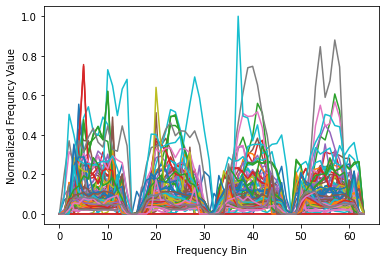

In [8]:
for i in range(X_test.shape[0]):
    plt.plot(X_test[i, :], label=f'Line {i + 1}')

plt.xlabel('Frequency Bin')
plt.ylabel('Normalized Frequncy Value')
plt.show()

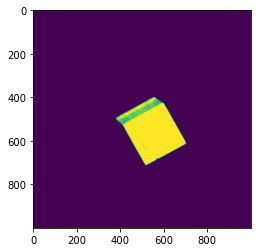

In [9]:
plt.imshow(image_array)

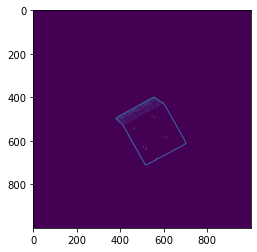

In [10]:
plt.imshow(edges_array)

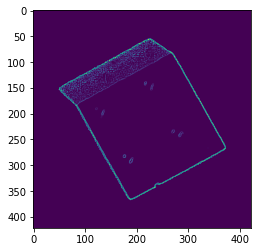

In [11]:
plt.imshow(cropped_image)

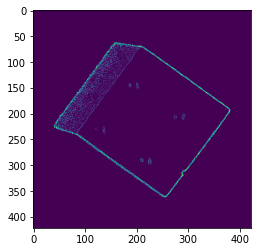

In [12]:
plt.imshow(rotated_array_30)

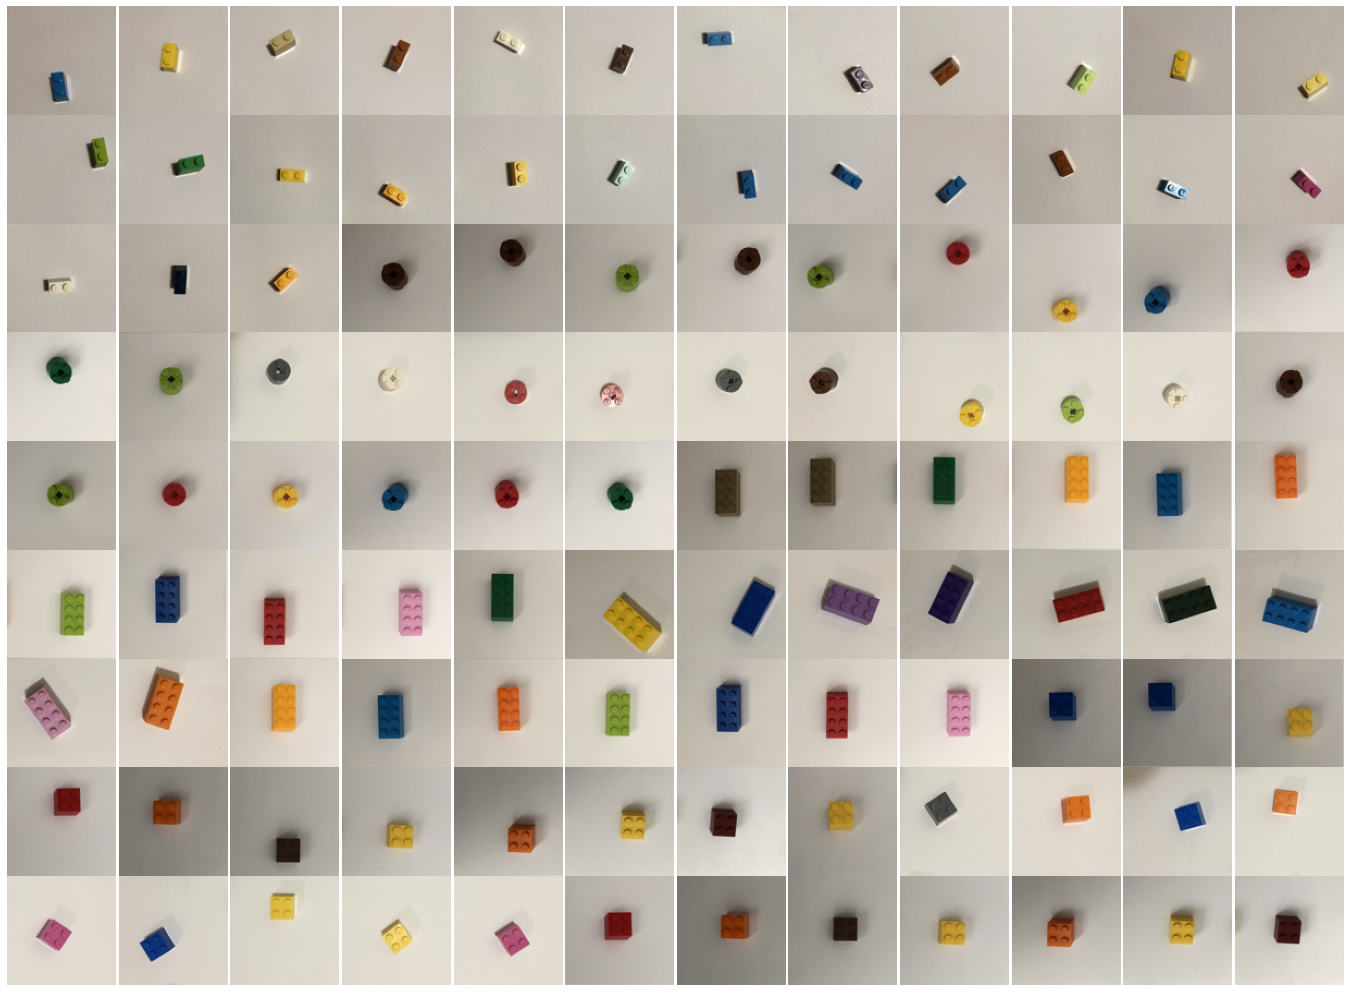

In [13]:
image_files = [f for f in os.listdir(training_path) if f.endswith('.png')]
grid_size=(9, 12)
image_size=(100, 100)
# Create a subplot grid
fig = plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))
gs = gridspec.GridSpec(grid_size[0], grid_size[1], wspace=0.0, hspace=0.0)

for i, file in enumerate(image_files):
    # Load image
    image_path = os.path.join(training_path, file)
    img = Image.open(image_path)
    img = img.resize(image_size)

    # Calculate subplot index
    row = i // grid_size[1]
    col = i % grid_size[1]

    # Add subplot
    ax = plt.subplot(gs[row, col])
    ax.imshow(img)
    ax.axis('off')

plt.show()
